# Predicting wind and solar generation from weather data using Machine Learning

In this notebook I describe how to predict wind and solar generation from weather data using a simple linear regression algorithm and a dataset containing energy production and weather information for Germany during 2016.



In [1]:
# import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 1. The data

The data I used in this analysis comes from Open Power System Data, a free-of-charge platform with data data on installed generation capacity by country/technology, individual power plants (conventional and renewable), and time series data. It can be found in:

https://open-power-system-data.org/

The platform contains data for 37 European countries, but in this project I’m going to focus on data for Germany in 2016 as an example. In particular, I’m going to use two datasets:
* Time series with load, wind and solar, prices in hourly resolution. 
* Weather data with wind speed, radiation, temperature and other measurements. Given the huge amount of data, the Open Power System Data platform provides a CSV file for the German dataset for 2016 and a script to download the data for other countries and years.

## 1.1. Renewable energy production data

### Read the data

First, we read the csv file containing the renewable energy production data relative to Germany. For that, we read the column containing the timestamp (whose column name starts with 'utc') and the columns containing German data (whose columns start with 'DE').

In [2]:
production = pd.read_csv("time_series_60min_singleindex_filtered.csv",
                        usecols=(lambda s: s.startswith('utc') | s.startswith('DE')),
                        parse_dates=[0], index_col=0)

In [3]:
production.head(3)

,DE_load_entsoe_power_statistics,DE_load_entsoe_transparency,DE_price_day_ahead,DE_solar_capacity,DE_solar_generation_actual,DE_solar_profile,DE_wind_capacity,DE_wind_generation_actual,DE_wind_profile,DE_wind_offshore_capacity,DE_wind_offshore_generation_actual,DE_wind_offshore_profile,DE_wind_onshore_capacity,DE_wind_onshore_generation_actual,DE_wind_onshore_profile
utc_timestamp,,,,,,,,,,,,,,,
2005-12-31 23:00:00+00:00,47823.0,NaN,32.10,2028.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16394.0,NaN,NaN
2006-01-01 00:00:00+00:00,47823.0,NaN,30.07,2028.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16394.0,NaN,NaN
2006-01-01 01:00:00+00:00,43444.0,NaN,27.94,2028.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16394.0,NaN,NaN


In [4]:
production.tail(3)

,DE_load_entsoe_power_statistics,DE_load_entsoe_transparency,DE_price_day_ahead,DE_solar_capacity,DE_solar_generation_actual,DE_solar_profile,DE_wind_capacity,DE_wind_generation_actual,DE_wind_profile,DE_wind_offshore_capacity,DE_wind_offshore_generation_actual,DE_wind_offshore_profile,DE_wind_onshore_capacity,DE_wind_onshore_generation_actual,DE_wind_onshore_profile
utc_timestamp,,,,,,,,,,,,,,,
2018-05-31 21:00:00+00:00,NaN,48462.0,43.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1843.0,NaN,NaN,NaN,NaN
2018-05-31 22:00:00+00:00,NaN,45898.0,42.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-31 23:00:00+00:00,NaN,43610.0,38.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The data file contains information between 2006 and 2017. We will only be interested in the data for 2016.

In [5]:
production = production.loc[production.index.year == 2016, :]

In [6]:
production.head(3)

,DE_load_entsoe_power_statistics,DE_load_entsoe_transparency,DE_price_day_ahead,DE_solar_capacity,DE_solar_generation_actual,DE_solar_profile,DE_wind_capacity,DE_wind_generation_actual,DE_wind_profile,DE_wind_offshore_capacity,DE_wind_offshore_generation_actual,DE_wind_offshore_profile,DE_wind_onshore_capacity,DE_wind_onshore_generation_actual,DE_wind_onshore_profile
utc_timestamp,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,41913.0,39396.0,22.39,39021.0,0.0,0.0,44325.0,8579.0,0.1936,3283.0,2286.0,0.6962,41042.0,6294.0,0.1533
2016-01-01 01:00:00+00:00,40331.0,37718.0,20.59,39021.0,0.0,0.0,44325.0,8542.0,0.1928,3283.0,2229.0,0.6788,41042.0,6314.0,0.1538
2016-01-01 02:00:00+00:00,39162.0,36692.0,16.81,39021.0,0.0,0.0,44325.0,8443.0,0.1905,3283.0,2012.0,0.6127,41042.0,6431.0,0.1567


In [9]:
production.tail(3)

,DE_load_entsoe_power_statistics,DE_load_entsoe_transparency,DE_price_day_ahead,DE_solar_capacity,DE_solar_generation_actual,DE_solar_profile,DE_wind_capacity,DE_wind_generation_actual,DE_wind_profile,DE_wind_offshore_capacity,DE_wind_offshore_generation_actual,DE_wind_offshore_profile,DE_wind_onshore_capacity,DE_wind_onshore_generation_actual,DE_wind_onshore_profile
utc_timestamp,,,,,,,,,,,,,,,
2016-12-31 21:00:00+00:00,50383.0,47205.0,33.71,40293.0,0.0,0.0,49569.0,14848.0,0.2995,4131.0,3306.0,0.8003,45438.0,11541.0,0.2540
2016-12-31 22:00:00+00:00,48988.0,45548.0,27.95,40293.0,0.0,0.0,49569.0,15056.0,0.3037,4131.0,3308.0,0.8008,45438.0,11748.0,0.2585
2016-12-31 23:00:00+00:00,47641.0,44512.0,20.96,40294.0,0.0,0.0,49569.0,15422.0,0.3111,4131.0,3303.0,0.7996,45438.0,12118.0,0.2667


In [10]:
production.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2016-01-01 00:00:00+00:00 to 2016-12-31 23:00:00+00:00
Data columns (total 15 columns):
DE_load_entsoe_power_statistics       8784 non-null float64
DE_load_entsoe_transparency           8784 non-null float64
DE_price_day_ahead                    8784 non-null float64
DE_solar_capacity                     8784 non-null float64
DE_solar_generation_actual            8784 non-null float64
DE_solar_profile                      8784 non-null float64
DE_wind_capacity                      8784 non-null float64
DE_wind_generation_actual             8784 non-null float64
DE_wind_profile                       8784 non-null float64
DE_wind_offshore_capacity             8784 non-null float64
DE_wind_offshore_generation_actual    8784 non-null float64
DE_wind_offshore_profile              8784 non-null float64
DE_wind_onshore_capacity              8784 non-null float64
DE_wind_onshore_generation_actual     8784 non-null float64
DE_wi

There 8784 entries, which correspond to the number of hours in a leap year like 2016.

### Exploratory Data Analysis

Let's plot the time series for the wind and solar generation to get a better idea of the properties of the dataset.

/Users/yangjian/miniconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


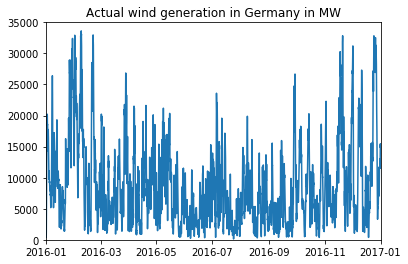

In [12]:
# create plot
plt.plot(production.index, production['DE_wind_generation_actual'])
plt.title('Actual wind generation in Germany in MW')
plt.xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2017-01-01'))
plt.ylim(0, 35000)

# save plot
plt.savefig("figs/wind.png", dpi=200)

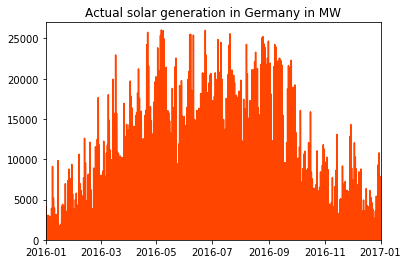

In [13]:
# create plot
plt.plot(production.index, production['DE_solar_generation_actual'], c='OrangeRed')
plt.title('Actual solar generation in Germany in MW')
plt.xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2017-01-01'))
plt.ylim(0, 27000)

# save plot
plt.savefig("figs/solar.png", dpi=200)

In [14]:
production_wind_solar = production[['DE_wind_generation_actual', 'DE_solar_generation_actual']]

## 1.2. Weather data

### Read the data

Next, we read the weather data for Germany in 2016 by reading the full csv file.

The data in the file contains the following:

* wind
    - v1: velocity [m/s] @ height h1 (2 meters above displacement height)
    - v2: velocity [m/s] @ height h2 (10 meters above displacement height)
    - v_50m: velocity [m/s] @ 50 meters above ground
    - h1: height above ground [m] (h1 = displacement height +2m)
    - h2: height above ground [m] (h2 = displacement height +10m)
    - z0: roughness length [m]
* solar parameters:
    - SWTDN: total top-of-the-atmosphere horizontal radiation [W/m²]
    - SWGDN: total ground horizontal radiation [W/m²]
* temperature data
    - T: Temperature [K] @ 2 meters above displacement height (see h1)
* air data
    - Rho: air density [kg/m³] @ surface
    - p: air pressure [Pa] @ surface

In [23]:
weather = pd.read_csv("weather_data_GER_2016.csv",
                     parse_dates=[0], index_col=0)

In [24]:
weather.head(3)

,cumulated hours,lat,lon,v1,v2,v_50m,h1,h2,z0,SWTDN,SWGDN,T,rho,p
timestamp,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,0,47.5,5.625,0.81,1.88,3.36,2,10,0.052526,0.0,0.0,277.350159,1.236413,99282.710938
2016-01-01 01:00:00+00:00,1,47.5,5.625,0.77,1.61,2.63,2,10,0.052510,0.0,0.0,277.025665,1.239390,99300.164062
2016-01-01 02:00:00+00:00,2,47.5,5.625,0.66,1.22,1.89,2,10,0.052495,0.0,0.0,277.223755,1.243861,99310.992188


In [25]:
weather.tail(3)

,cumulated hours,lat,lon,v1,v2,v_50m,h1,h2,z0,SWTDN,SWGDN,T,rho,p
timestamp,,,,,,,,,,,,,,
2016-12-31 21:00:00+00:00,8781,55.0,15.0,10.49,12.65,14.38,2,10,0.001014,0.0,0.0,278.634644,1.270996,101653.398438
2016-12-31 22:00:00+00:00,8782,55.0,15.0,10.47,12.63,14.41,2,10,0.001009,0.0,0.0,278.678162,1.270252,101609.484375
2016-12-31 23:00:00+00:00,8783,55.0,15.0,10.39,12.53,14.33,2,10,0.000993,0.0,0.0,278.720184,1.269202,101545.859375


In [26]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2248704 entries, 2016-01-01 00:00:00+00:00 to 2016-12-31 23:00:00+00:00
Data columns (total 14 columns):
cumulated hours    int64
lat                float64
lon                float64
v1                 float64
v2                 float64
v_50m              float64
h1                 int64
h2                 int64
z0                 float64
SWTDN              float64
SWGDN              float64
T                  float64
rho                float64
p                  float64
dtypes: float64(11), int64(3)
memory usage: 257.3 MB


Note that the data is given by chuncks of the German geographical territory, each determined by its latitute ('lat') and longitute ('lon'). Each chunck corresponds to the resolution of the MERRA-2 grid (which was used to obtain the data), which is 0.5º x 0.625º.

For example, the data for the time 2016-01-01 00:00:00 is the following:

In [27]:
weather.loc[weather.index == '2016-01-01 00:00:00', :]

,cumulated hours,lat,lon,v1,v2,v_50m,h1,h2,z0,SWTDN,SWGDN,T,rho,p
timestamp,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,0,47.5,5.625,0.81,1.88,3.36,2,10,0.052526,0.0,0.0,277.350159,1.236413,99282.710938
2016-01-01 00:00:00+00:00,0,47.5,6.250,0.85,1.77,3.69,2,10,0.163823,0.0,0.0,277.609924,1.226037,98194.710938
2016-01-01 00:00:00+00:00,0,47.5,6.875,0.94,1.94,3.79,3,11,0.286626,0.0,0.0,276.850159,1.205101,96186.710938
2016-01-01 00:00:00+00:00,0,47.5,7.500,0.84,1.68,2.82,2,10,0.109472,0.0,0.0,276.414612,1.200341,95874.710938
2016-01-01 00:00:00+00:00,0,47.5,8.125,0.74,1.56,2.51,2,10,0.066503,0.0,0.0,276.039612,1.202233,96050.710938
2016-01-01 00:00:00+00:00,0,47.5,8.750,0.76,1.49,2.37,2,10,0.051061,0.0,0.0,275.898987,1.201012,95842.710938
2016-01-01 00:00:00+00:00,0,47.5,9.375,0.75,1.27,1.83,2,10,0.082921,0.0,0.0,275.578674,1.181908,94178.710938
2016-01-01 00:00:00+00:00,0,47.5,10.000,0.88,1.59,2.32,4,12,0.398931,0.0,0.0,274.123596,1.146264,90998.710938
2016-01-01 00:00:00+00:00,0,47.5,10.625,0.81,1.38,1.93,6,14,0.813970,0.0,0.0,273.670471,1.117516,88518.710938


Therefore, for any given hour, we have data for 256 'chuncks' of Germany. Dividing the total number of entries by the number of 'chuncks' returns the expected number of hours of a leap year.

In [17]:
2248704/256

8784.0

Averaging over all the 'chuncks':

In [28]:
weather_by_day = weather.groupby(weather.index).mean()

In [30]:
weather_by_day.head(25)

,cumulated hours,lat,lon,v1,v2,v_50m,h1,h2,z0,SWTDN,SWGDN,T,rho,p
timestamp,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,0.0,51.25,10.3125,2.616758,3.714414,5.132500,2.546875,10.546875,0.164370,0.000000,0.000000,275.296747,1.253185,99281.007812
2016-01-01 01:00:00+00:00,1.0,51.25,10.3125,2.564375,3.631055,4.976094,2.546875,10.546875,0.164331,0.000000,0.000000,275.255473,1.253778,99288.492188
2016-01-01 02:00:00+00:00,2.0,51.25,10.3125,2.480859,3.516328,4.794688,2.546875,10.546875,0.164288,0.000000,0.000000,275.217089,1.254304,99296.398438
2016-01-01 03:00:00+00:00,3.0,51.25,10.3125,2.397148,3.404961,4.664023,2.546875,10.546875,0.164239,0.000000,0.000000,275.211715,1.254562,99306.695312
2016-01-01 04:00:00+00:00,4.0,51.25,10.3125,2.305703,3.286602,4.566289,2.546875,10.546875,0.164199,0.000000,0.000000,275.193369,1.254733,99319.750000
2016-01-01 05:00:00+00:00,5.0,51.25,10.3125,2.207227,3.160312,4.445078,2.546875,10.546875,0.164153,0.000000,0.000000,275.184228,1.254969,99336.710938
2016-01-01 06:00:00+00:00,6.0,51.25,10.3125,2.099336,3.027148,4.291758,2.546875,10.546875,0.164116,0.029503,0.002406,275.151314,1.255247,99357.078125
2016-01-01 07:00:00+00:00,7.0,51.25,10.3125,2.001992,2.903750,4.116836,2.542969,10.542969,0.164068,32.701265,4.885147,275.175961,1.255487,99383.765625
2016-01-01 08:00:00+00:00,8.0,51.25,10.3125,2.061836,2.915977,3.855273,2.542969,10.542969,0.164031,167.523132,34.330536,275.612767,1.255295,99415.406250


### Exploratory Data Analysis

Let's plot the various weather-related quantities during 2016 to get a better idea of the properties of the dataset.

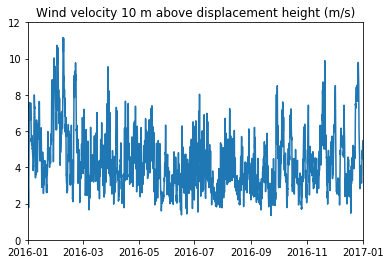

In [31]:
# create plot
plt.plot(weather_by_day.index, weather_by_day['v2'])
plt.title('Wind velocity 10 m above displacement height (m/s)')
plt.xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2017-01-01'))
plt.ylim(0, 12)

# save plot
plt.savefig("figs/v1.png", dpi=200)

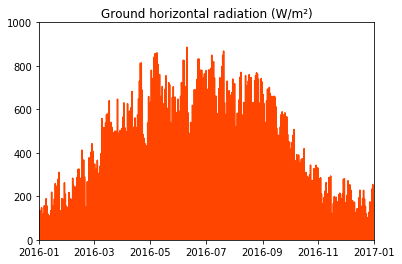

In [21]:
# create plot
plt.plot(weather_by_day.index, weather_by_day['SWGDN'], c='OrangeRed')
plt.title('Ground horizontal radiation (W/m²)')
plt.xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2017-01-01'))
plt.ylim(0, 1000)

# save plot
plt.savefig("figs/radiation.png", dpi=200)

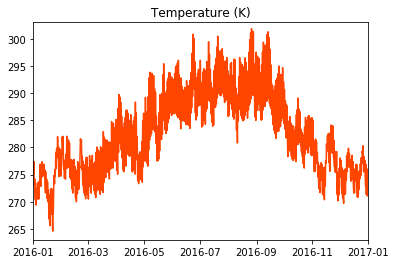

In [32]:
# create plot
plt.plot(weather_by_day.index, weather_by_day['T'], c='OrangeRed')
plt.title('Temperature (K)')
plt.xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2017-01-01'))
plt.ylim(263, 303)

# save plot
plt.savefig("figs/temperature_K.png", dpi=200)

Let's use the more common Celsius units for the temperature.

In [33]:
weather_by_day['T (C)'] = weather_by_day['T'] - 273.15

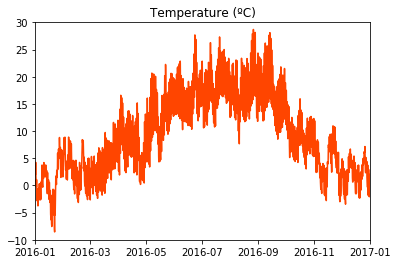

In [34]:
# create plot
plt.plot(weather_by_day.index, weather_by_day['T (C)'], c='OrangeRed')
plt.title('Temperature (ºC)')
plt.xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2017-01-01'))
plt.ylim(-10, 30)

# save plot
plt.savefig("figs/temperature_C.png", dpi=200)

(735964.0, 736330.0)

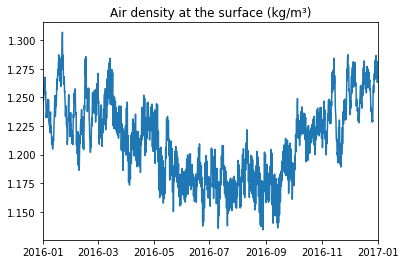

In [35]:
# create plot
plt.plot(weather_by_day.index, weather_by_day['rho'])
plt.title('Air density at the surface (kg/m³)')
plt.xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2017-01-01'))

In [37]:
weather_by_day.index

DatetimeIndex(['2016-01-01 00:00:00+00:00', '2016-01-01 01:00:00+00:00',
               '2016-01-01 02:00:00+00:00', '2016-01-01 03:00:00+00:00',
               '2016-01-01 04:00:00+00:00', '2016-01-01 05:00:00+00:00',
               '2016-01-01 06:00:00+00:00', '2016-01-01 07:00:00+00:00',
               '2016-01-01 08:00:00+00:00', '2016-01-01 09:00:00+00:00',
               ...
               '2016-12-31 14:00:00+00:00', '2016-12-31 15:00:00+00:00',
               '2016-12-31 16:00:00+00:00', '2016-12-31 17:00:00+00:00',
               '2016-12-31 18:00:00+00:00', '2016-12-31 19:00:00+00:00',
               '2016-12-31 20:00:00+00:00', '2016-12-31 21:00:00+00:00',
               '2016-12-31 22:00:00+00:00', '2016-12-31 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='timestamp', length=8784, freq=None)

(735964.0, 736330.0)

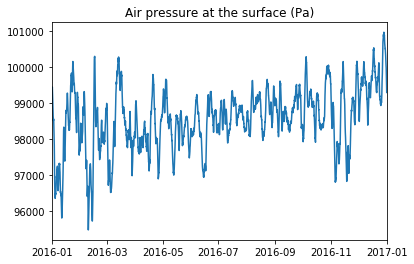

In [36]:
# create plot
plt.plot(weather_by_day.index, weather_by_day['p'])
plt.title('Air pressure at the surface (Pa)')
plt.xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2017-01-01'))

## 2. Merge DataFrames

As suggested by the above plots from both datasets (and by common sense), there seems to be some correlation between the wind and solar generation and some of the measured weather quantities. 

First, let's merge the two DataFrames into a single DataFrame.

In [38]:
# merge production_wind_solar and weather_by_day DataFrames
combined = pd.merge(production_wind_solar, weather_by_day, how='left', left_index=True, right_index=True)

# drop redundant 'T (C)' column
combined = combined.drop('T (C)', axis=1)

In [39]:
combined.head()

,DE_wind_generation_actual,DE_solar_generation_actual,cumulated hours,lat,lon,v1,v2,v_50m,h1,h2,z0,SWTDN,SWGDN,T,rho,p
utc_timestamp,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,8579.0,0.0,0.0,51.25,10.3125,2.616758,3.714414,5.132500,2.546875,10.546875,0.164370,0.0,0.0,275.296747,1.253185,99281.007812
2016-01-01 01:00:00+00:00,8542.0,0.0,1.0,51.25,10.3125,2.564375,3.631055,4.976094,2.546875,10.546875,0.164331,0.0,0.0,275.255473,1.253778,99288.492188
2016-01-01 02:00:00+00:00,8443.0,0.0,2.0,51.25,10.3125,2.480859,3.516328,4.794688,2.546875,10.546875,0.164288,0.0,0.0,275.217089,1.254304,99296.398438
2016-01-01 03:00:00+00:00,8295.0,0.0,3.0,51.25,10.3125,2.397148,3.404961,4.664023,2.546875,10.546875,0.164239,0.0,0.0,275.211715,1.254562,99306.695312
2016-01-01 04:00:00+00:00,7319.0,0.0,4.0,51.25,10.3125,2.305703,3.286602,4.566289,2.546875,10.546875,0.164199,0.0,0.0,275.193369,1.254733,99319.750000


Further evidence for the apparent correlation between certain quantities can be obtained from the following plots, in which the wind and solar generation is shown as a function of the several weather quantities.

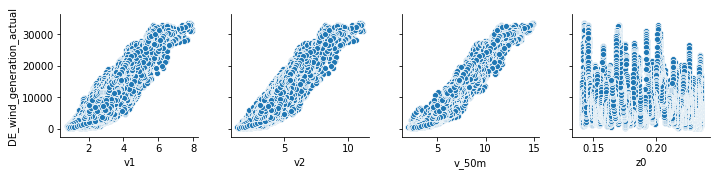

In [40]:
sns.pairplot(combined, x_vars=['v1', 'v2', 'v_50m', 'z0'], y_vars=['DE_wind_generation_actual'])

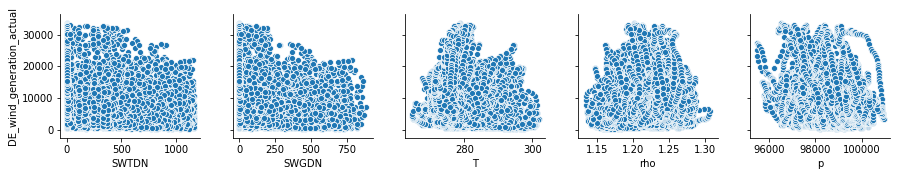

In [41]:
sns.pairplot(combined, x_vars=['SWTDN', 'SWGDN', 'T', 'rho', 'p'], y_vars=['DE_wind_generation_actual'])

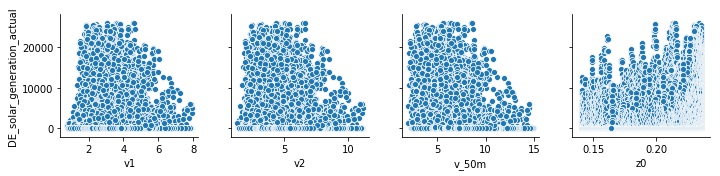

In [42]:
sns.pairplot(combined, x_vars=['v1', 'v2', 'v_50m', 'z0'], y_vars=['DE_solar_generation_actual'])

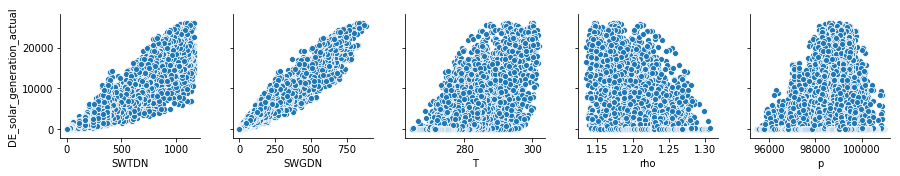

In [43]:
sns.pairplot(combined, x_vars=['SWTDN', 'SWGDN', 'T', 'rho', 'p'], y_vars=['DE_solar_generation_actual'])

There seems to be a linear relation between the wind generation and the wind velocities v1, v2 and v_50m, but not the other quantities.

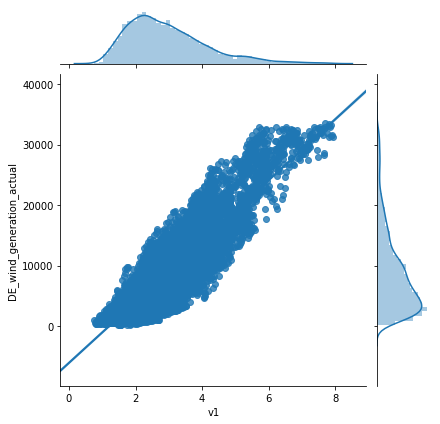

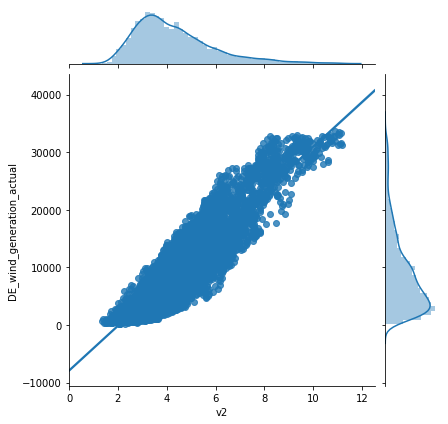

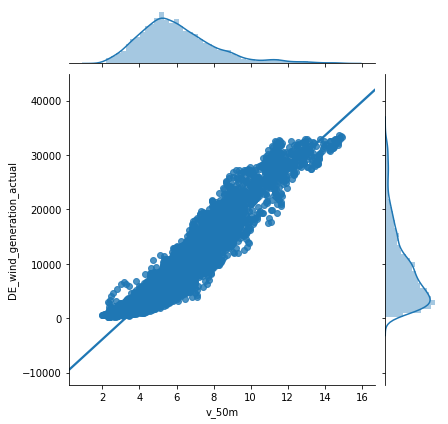

In [44]:
sns.jointplot(x='v1', y='DE_wind_generation_actual', data=combined, kind='reg')
sns.jointplot(x='v2', y='DE_wind_generation_actual', data=combined, kind='reg')
sns.jointplot(x='v_50m', y='DE_wind_generation_actual', data=combined, kind='reg')

Similarly, there seems to be a linear relation between the solar generation and the top-of-the-atmosphere and ground radiation.

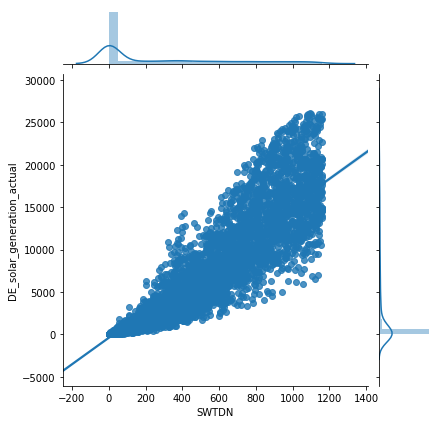

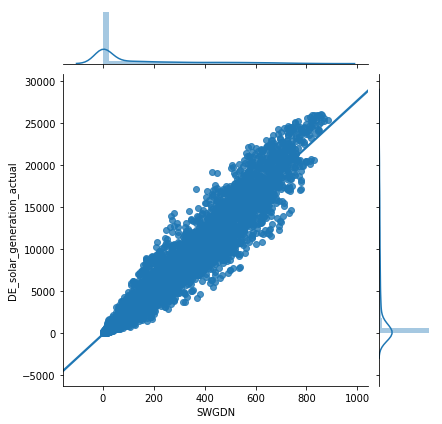

In [45]:
sns.jointplot(x='SWTDN', y='DE_solar_generation_actual', data=combined, kind='reg')
sns.jointplot(x='SWGDN', y='DE_solar_generation_actual', data=combined, kind='reg')

## 3. Linear regression algorithm

Given the observations above, I’m going to try a linear regression algorithm in order to predict the wind and solar generation from some of the above weather quantities.

In [46]:
# import necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# instantiate LinearRegression
lr = LinearRegression()

## 3.1. Wind generation

To predict the wind generation, we construct the features matrix `X_wind` with the features v1, v2 and v_50m, and the target `Y_wind` with actual wind generation.

In [47]:
X_wind = combined[['v1', 'v2', 'v_50m', 'z0']]
y_wind = combined['DE_wind_generation_actual']

Then, we implement a 5-fold CV procedure.

In [48]:
scores_wind = cross_val_score(lr, X_wind, y_wind, cv=5)
print(scores_wind, "\naverage =", np.mean(scores_wind))

[0.83709573 0.89114316 0.81583076 0.87216318 0.85405042] 
average = 0.8540566509869564


/Users/yangjian/miniconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


The first line contains the five values of $R^2$ for each of the 5 folds in the cross validation procedure, whereas the second line is their average. We see that our linear model has an $R^2$ of approximately 0.87, which is quite good for such a simple model! We can make good predictions about the wind generation in Germany in 2016 given only the wind velocities at different heights.

## 3.2. Solar generation

To predict the solar generation, we follow a very similar procedure. We again construct the features matrix `X_solar`, but now with the features SWTDN, SWGDN and T, and the target `Y_solar` with actual solar generation.

In [49]:
X_solar = combined[['SWTDN', 'SWGDN', 'T']]
y_solar = combined['DE_solar_generation_actual']

Then, we implement a 5-fold CV procedure:

In [50]:
scores_solar = cross_val_score(lr, X_solar, y_solar, cv=5)
print(scores_solar, "\naverage =", np.mean(scores_solar))

[0.8901974  0.95027431 0.95982151 0.95090201 0.8715077 ] 
average = 0.9245405855731834


We get an even better value of $R^2$! We can make good predictions about the solar generation in Germany in 2016 given only the temperature and top-of-the-atmosphere and ground radiation.